###Exercise 1: Discrete distributions
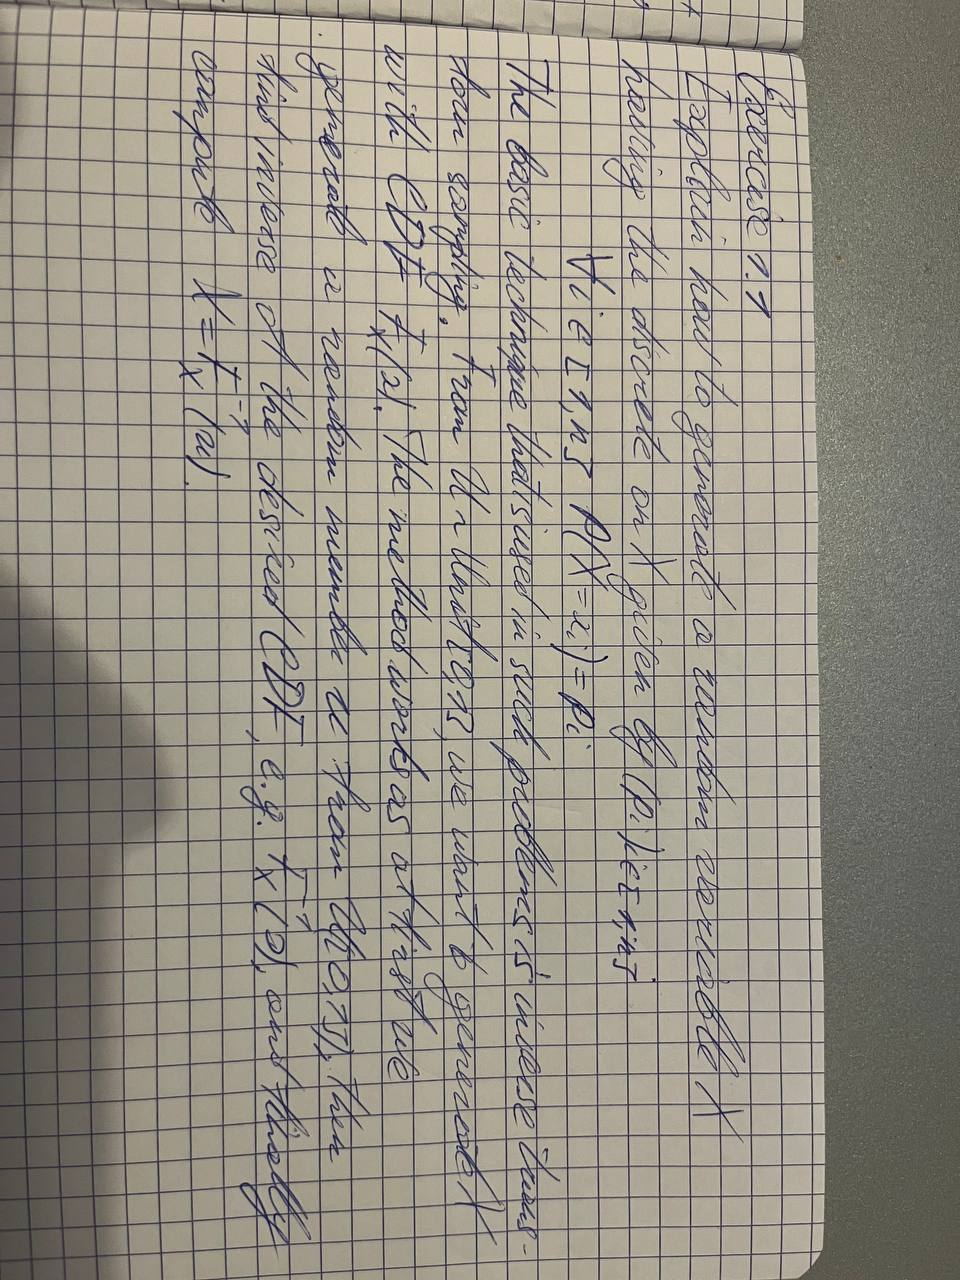

2. Write (in Python, Julia, Matlab, Octave. . . ) the corresponding algorithm.

In [1]:
import numpy as np
def Discrete(prob, n):
    F_X = np.concatenate([[0.0], np.cumsum(prob, dtype=float)])
    uniform = np.random.uniform(0, 1, n)
    X = np.zeros(n)
    for i, u in enumerate(uniform):
        X[i] = np.where(F_X <= u)[0][len(np.where(F_X <= u)[0])-1]
    return X

3. Generate a sequence (Xi) of i.i.d. random variables having the same distribution as X for large values of N. Compare the empirical distribution to the theoretical distribution of X.

T-test p-value: 0.9973264443620231
Levene test's p-value: 0.9863974259950872


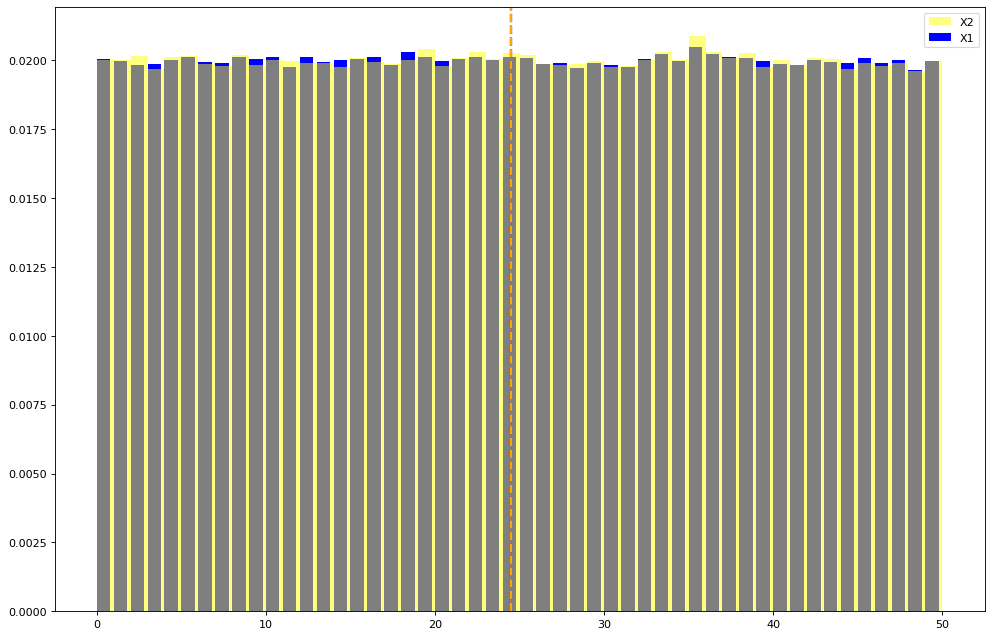

In [2]:
import matplotlib.pyplot as plt
from scipy import stats
n = int(1e6)
X = np.random.uniform(0, 1, n)
p, bins = np.histogram(X, bins=50)
p = p/np.sum(p)
X1 = range(0, len(p))
X2 = Discrete(p, n)

print("T-test p-value: {}".format(stats.ttest_ind(X1, X2)[1]))
print("Levene test's p-value: {}".format(stats.levene(X1, X2)[1]))
plt.figure(figsize=(15, 10), dpi=80)
# visualization
plt.bar(X1, p, fill=True, label='X1', align='edge', color='blue')
plt.axvline(np.mean(X1), linestyle='--', linewidth=2, color='blue')
plt.hist(X2, range(0, len(p)+1), density=True, alpha = 0.5, label='X2', color='yellow')
plt.axvline(np.mean(X2), linestyle='--', linewidth=2, color='orange')
plt.legend();

As we can see p-values are larger that 0.05, so the distribution have same means and variations. And looking by the graph we can see that distributions are the same. The bigger n, the less visible is difference.

### Exercise 2: Gaussian mixture model and the EM algorithm

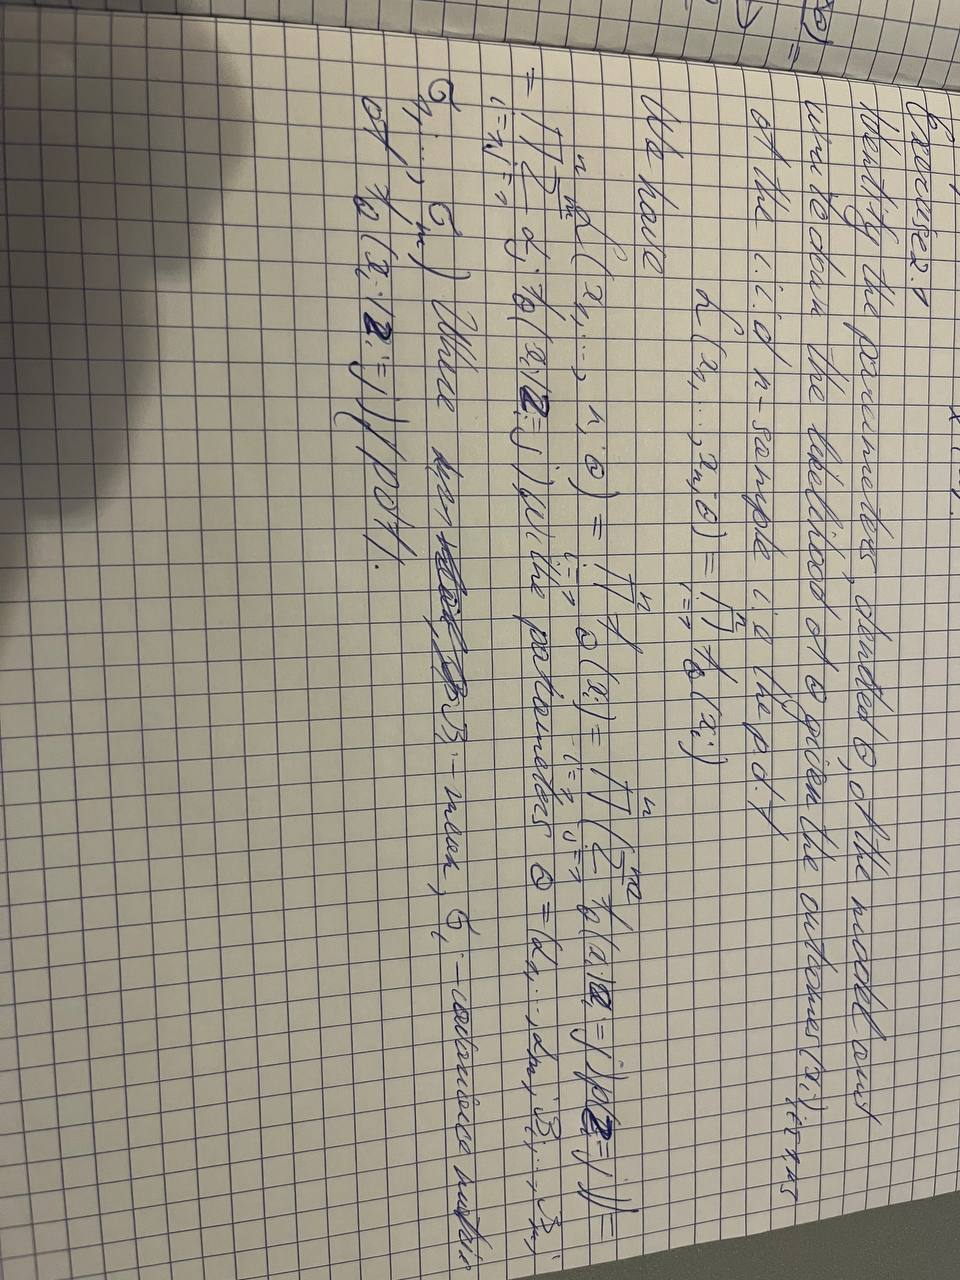

2. Sample a set of observation according to a Gaussian mixture law, with the parameters of your choice. Use the hierarchical model and the first exercise.

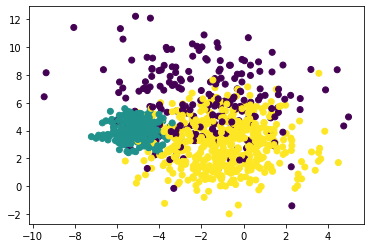

In [3]:
def GaussianM(theta, n):
    X = Discrete(theta[1], n)
    GM = []
    c = []
    for i, x in enumerate(X):
        GM.append(np.random.multivariate_normal(theta[0][int(x)], theta[2][int(x)]))
        c.append(x)
    return np.array(GM), c
n = int(1e3)
theta = ([np.array([-2, 6]), np.array([-5, 4]), np.array([-1, 3])],
         np.array([0.2, 0.3, 0.5]),
         np.array([5*np.identity(2), 0.5*np.identity(2), 3*np.identity(2)]))
GM, c = GaussianM(theta, n)
plt.scatter(GM[:, 0], GM[:, 1], c=c);

3. Implement the EM algorithm in order to estimate the parameters of this model from your obser-vations and plot the log-likelihood over the number of iterations of the algorithm.

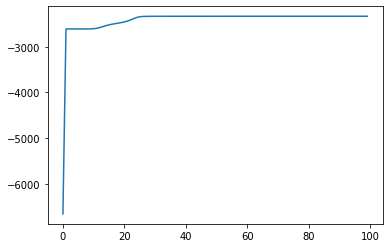

In [4]:
def e_step(X, mu, alpha, sigma, k):
    n = X.shape[0]
    t = np.zeros((n, k))
    for j in range(k):
        a = -(((X-mu[j])@np.linalg.inv(sigma[j])*(X-mu[j])).sum(axis=1))/2
        t[:, j] = alpha[j]/np.sqrt(np.linalg.det(sigma[j]))*np.exp(a)
    return t

def m_step(X, mu, alpha, sigma, k, t):
    n = X.shape[0]
    for j in range(k):
        alpha[j] = t[:, j].sum(axis=0)
        mu[j] = np.sum(t[:, j].reshape(-1, 1)*X, axis=0)/alpha[j]
        numerator = 0
        for i in range(n):
            X_new = (X[i] - mu[j]).reshape((1, 2))
            numerator = numerator + t[i, j]*np.dot(X_new.T, X_new)
        sigma[j] = numerator/alpha[j]
    alpha = alpha/alpha.sum()
    return mu, alpha, sigma

def exp_max(X, k=3, iter=100):
    mu = np.random.random((k,2))
    alpha = np.ones(k)/k
    sigma = np.zeros((k, 2, 2))
    X_new = X-np.mean(X, axis=0)
    for j in range(k):
        sigma[j] = np.mean(np.dot(X_new.T, X_new))/k*np.identity(2)
    LL_list = []
    for iter in range(iter):
        t = e_step(X, mu, alpha, sigma, k)
        LL_list.append(sum(np.log(t.sum(axis=1))))
        t = t/t.sum(axis=1).reshape(-1, 1)
        mu, alpha, sigma = m_step(X, mu, alpha, sigma, k, t)
    return (mu, alpha, sigma), LL_list

result = exp_max(GM)
plt.plot(result[-1]);

4. Are the estimated parameters far from the original ones ?

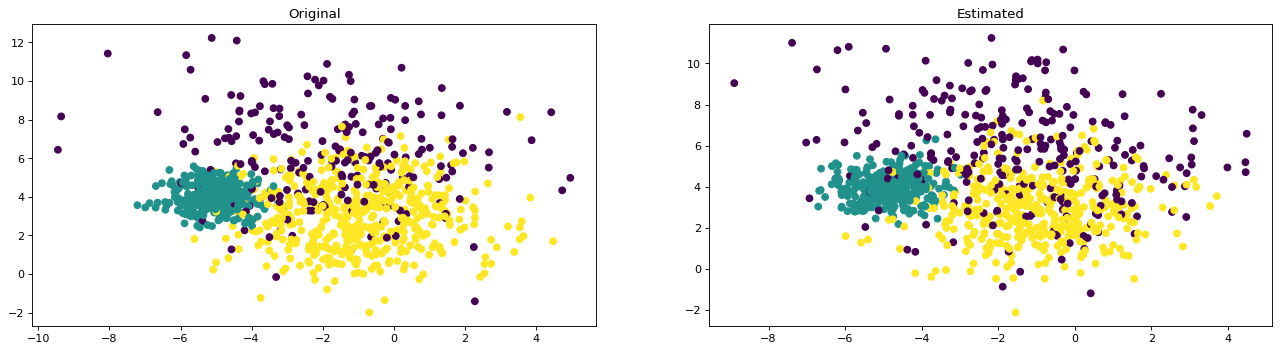

In [5]:
plt.figure(figsize=(20, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.scatter(GM[:, 0], GM[:, 1], c=c)
plt.title("Original")
plt.subplot(1, 2, 2)
GM_est, c_est = GaussianM((result[0][0], result[0][1], result[0][2]), n)
plt.scatter(GM_est[:, 0], GM_est[:, 1], c=c_est)
plt.title("Estimated");


As we can see from the graphs, the parameters are not far. 

5. Application: Download the data Crude Birth/Death Rate– See esa.un.org/unpd/wpp/forinstance – and plot the associated scatter graph. What do you think about using a Gaussian mixture model ?

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


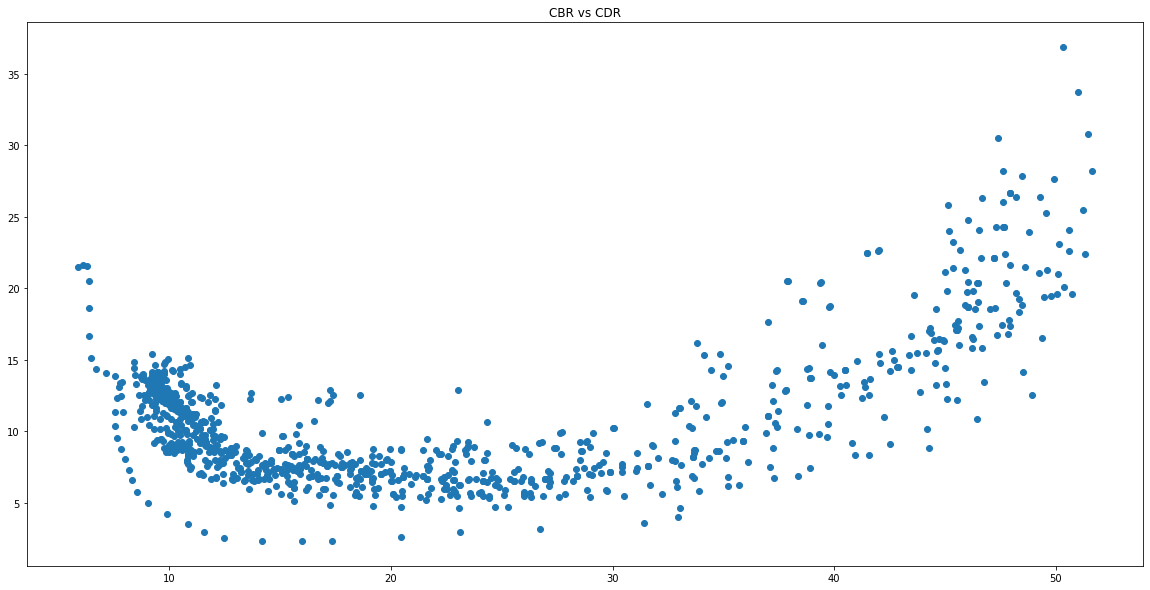

In [6]:
from google.colab import drive
import pandas as pd
drive.mount('/gdrive')
%cd /gdrive
path = '/gdrive/My Drive/Colab Notebooks/Datafiles/CompStat/WPP2019_Period_Indicators_Medium.csv'
df = pd.read_csv(path)
df = df[['CBR','CDR']].dropna()
X = np.array(df.head(1000))
plt.figure(figsize = (20, 10))
plt.scatter(X[:,0],X[:,1])
plt.title('CBR vs CDR');

As we can see, the single gaussian clearly is not enough and we see some differention on the plots, therefore GMM can show some results. Also, the data comes from different sources, so by nature there should be some differnce in the set of points. 

6. Estimate the parameters θ for different values of m, try to interpret them and compute the BIC. Plot the corresponding p.d.f over the scatter plot. (In Python, you can use plt.contour)

Best m is:  9


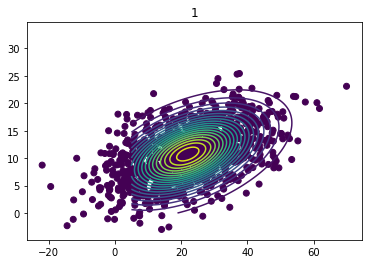

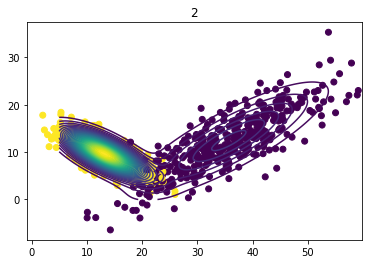

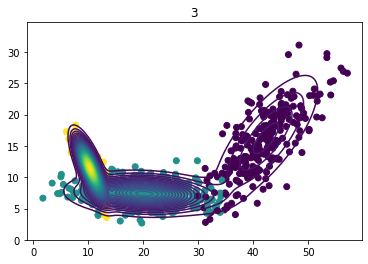

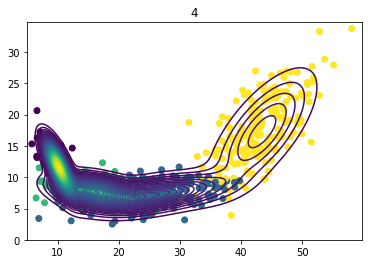

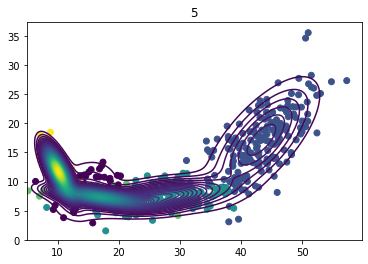

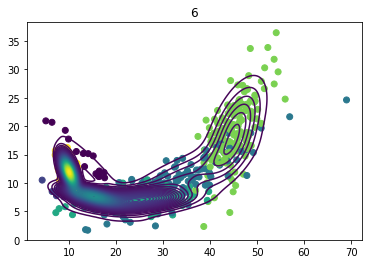

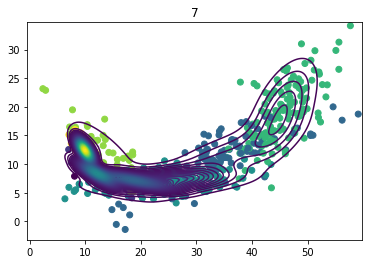

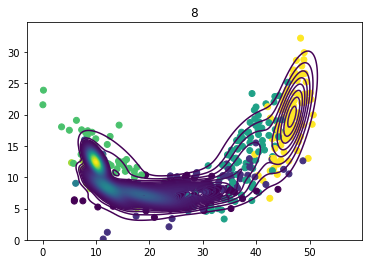

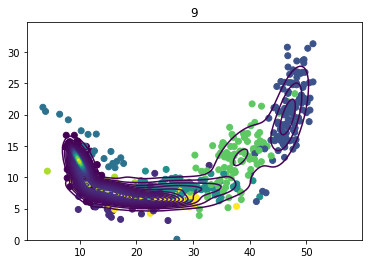

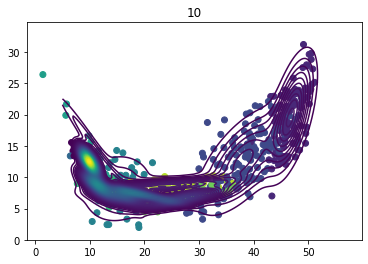

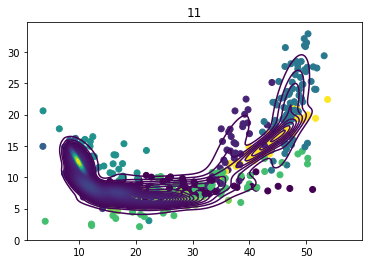

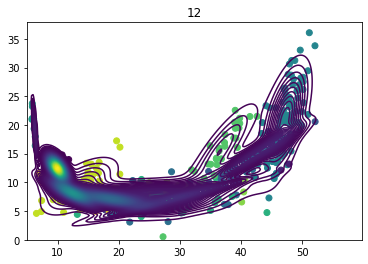

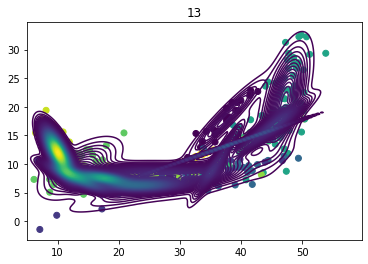

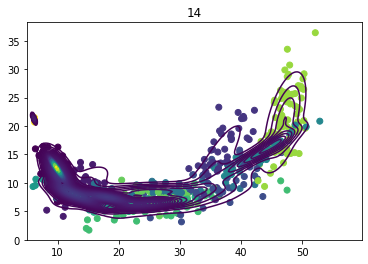

In [7]:
BIC = []
for m in range(1, 15):
    theta, L = exp_max(X, k = m, iter=100)
    BIC.append(-2*L[-1] + (5*m-1)*np.log(1000))
    GM, c = GaussianM(theta, 1000)
    fig, ax = plt.subplots()
    plt.title(m)
    plt.scatter(GM[:, 0], GM[:, 1], c=c)
    x1 = np.arange(5, 60, 0.25)
    lx = len(x1)
    y1 = np.arange(0,35, 0.25)
    ly = len(y1)
    x1, y1 = np.meshgrid(x1, y1)
    XY = np.concatenate((x1.reshape(ly, lx, 1, 1, 1) - theta[0][:, 0].reshape(m, 1, 1),
                         y1.reshape(ly, lx, 1, 1, 1) - theta[0][:, 1].reshape(m, 1, 1)), 3)
    c = (XY.transpose((0, 1, 2, 4, 3)) @ np.linalg.inv(theta[2]).reshape(1, 1, m, 2, 2) @ XY).reshape(ly, lx, m)
    z1 = (np.exp(-0.5 * c) * theta[1] / (np.linalg.det(theta[2]) * (2*np.pi)**2 + 1e-10) ** 0.5).sum(2)
    plt.contour(x1, y1, z1, levels=20*m)
    
print("Best m is: ", np.argmin(np.array(BIC)) + 1)


1.Implement a simple importance sampling procedure for the previous functions.Be careful when sampling from q supported on R to discard any samples x < 0 when p is supported only for x > 0.

In [207]:
import numpy as np
def f(x):
    if x < 0: 
      return 0
    else:
      return 2*np.sin(np.pi/1.5*x)
def p(x):
    if x < 0: 
      return 0
    else:
      return x**((1.65)-1)*np.exp(-x**2/2)
def q(x, mean, var):
    return 2*np.exp(-(mean-x)**2/(2*var))/(np.sqrt(2*np.pi*var))
f = np.vectorize(f)
p = np.vectorize(p)
q = np.vectorize(q)
def PosNorm(n, mean, var):
  X = []
  while len(X) < n:
    x = np.random.normal(size=1, loc=mean, scale=var)
    if x > 0:
      X.append(x)
  return np.array(X)
def IS(n, mean, var):
    X = PosNorm(n, mean, var).reshape(n,)
    X = X[np.argsort(X)]
    w = np.divide(p(X), q(X, mean, var))
    return np.sum(np.multiply(w/sum(w), f(X))), w
print('Estimate = {}'.format(IS(10000, 0.8, 1.5)[0]))

Estimate = 0.6762312009599234


2. Compute the mean and the variance of the importance sampling estimate of E. You can use several sample sizes, for instance N = 10, 100, 1000 and 10000.

In [211]:
import pandas as pd
means = []
variances = []
weights1 = []
N = [10, 100, 1000, 10000, 100000]
for n in N:
  E_list = []
  for i in range(100):
    E, w = IS(n, 0.8, 1.5)
    E_list.append(E)
  E_list = np.array(E_list)
  means.append(np.mean(E_list))
  variances.append(np.std(E_list))
  weights1.append(w)
pd.DataFrame(data = [means, variances], index = ["Mean", "Variance"], columns = N)

,10,100,1000,10000,100000
Mean,0.653671,0.662940,0.690603,0.684336,0.682396
Variance,0.390856,0.133655,0.041836,0.013974,0.004271


As we can see the more we have samples the more stable mean and the less is variance of the estimate. 

3. Shift the mean of q, μ = 6, so that the centers of mass for each distribution are far apart and repeat the experiment. Compare the importance weights for both values of μ.

In [212]:
import matplotlib.pyplot as plt
means = []
variances = []
weights2 = []
for n in N:
  E_list = []
  for i in range(100):
    E, w = IS(n, 6, 1.5)
    E_list.append(E)
  E_list = np.array(E_list)
  means.append(np.mean(E_list))
  variances.append(np.std(E_list))
  weights2.append(w)
pd.DataFrame(data = [means, variances], index = ["Mean", "Variance"], columns = N)

,10,100,1000,10000,100000
Mean,0.167378,-0.576295,0.439643,1.172395,1.185743
Variance,1.410852,1.161363,1.135652,0.229773,0.081422


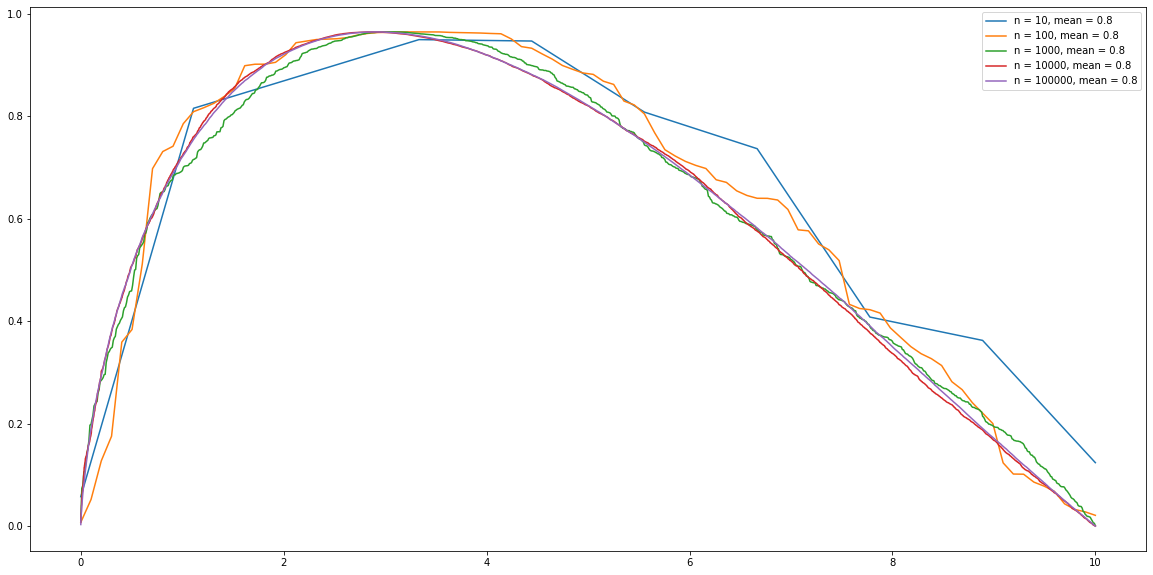

In [213]:
plt.figure(figsize = (20, 10))
for i,w in enumerate(weights1):
    plt.plot(np.linspace(0,10,len(w)),w,label = "n = {}, mean = 0.8".format(N[i]))
plt.legend()
plt.show()

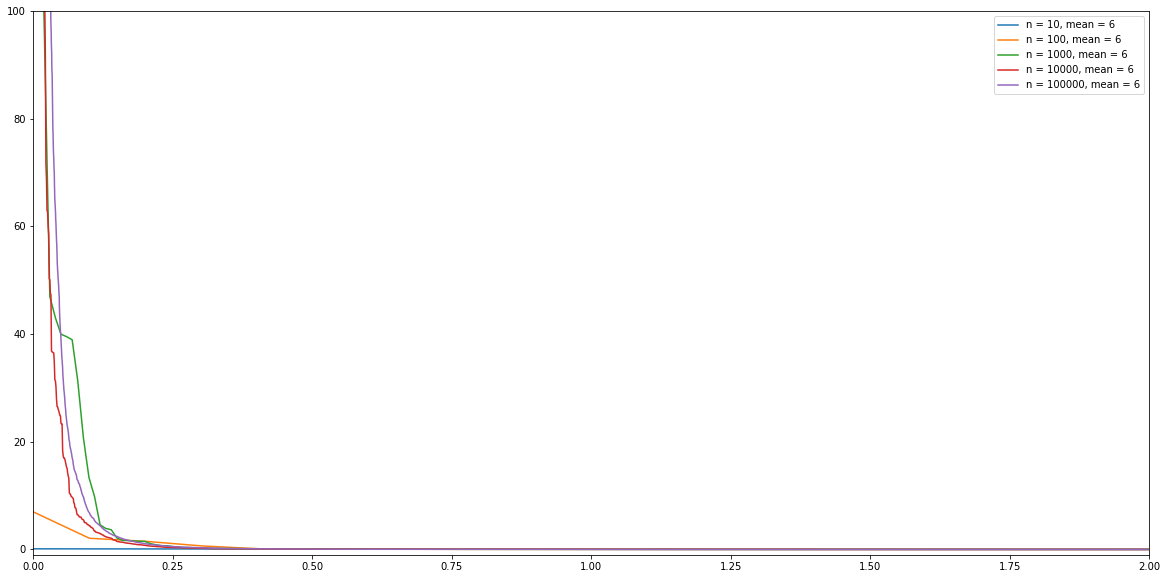

In [214]:
plt.figure(figsize = (20, 10))
for i,w in enumerate(weights2):
    plt.plot(np.linspace(0,10,len(w)),w, label = "n = {}, mean = 6".format(N[i]))
plt.xlim(0,2)
plt.ylim(-1,100)
plt.legend()
plt.show();

As we can see graphs of the weights are not close to each other. For mean = 6 the amount of examples to get stability is bigger than for smaller mean. 